In [263]:
from matplotlib import pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
import pickle
from pandas_parallel_apply import DataFrameParallel, SeriesParallel

In [2]:
spark_executor_cores = "8"

spark = SparkSession.builder \
    .config("spark.driver.extraClassPath", "../lib/mysql-connector-j-9.1.0.jar") \
    .config("spark.executors.core", spark_executor_cores) \
    .appName('SparkByExamples.com') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/14 19:07:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Carrega os dados do Banco transacional para análise

In [4]:
spark.read.format("jdbc") \
    .option("url", "jdbc:mysql://localhost/book_store") \
    .option("dbtable", "book_store.users") \
    .option("user", "book_store") \
    .option("password", "1234") \
    .load().createOrReplaceTempView("tmp_db_users")

In [5]:
spark.read.format("jdbc") \
    .option("url", "jdbc:mysql://localhost/book_store") \
    .option("dbtable", "book_store.books") \
    .option("user", "book_store") \
    .option("password", "1234") \
    .load().createOrReplaceTempView("tmp_db_books")

In [6]:
spark.read.format("jdbc") \
    .option("url", "jdbc:mysql://localhost/book_store") \
    .option("dbtable", "book_store.ratings") \
    .option("user", "book_store") \
    .option("password", "1234") \
    .load().createOrReplaceTempView("tmp_db_ratings")

# Quantidades de Livros / Usuários / Avaliações

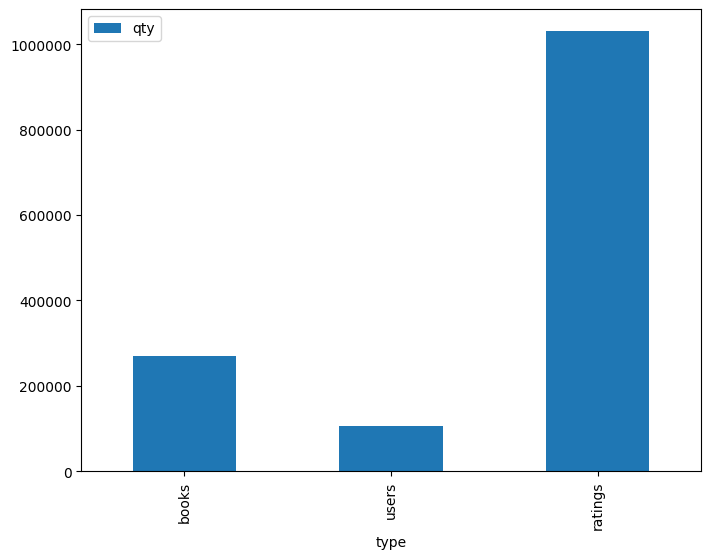

In [83]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.ticklabel_format(useOffset=False, style='plain')
spark.sql("""
    SELECT 
        'books' as type,
        count(1) as qty
    FROM tmp_db_books
    UNION ALL
    SELECT 
        'users' as type,
        count(1) as qty
    FROM tmp_db_users
    UNION ALL
    SELECT 
        'ratings' as type,
        count(1) as qty
    FROM tmp_db_ratings
""").toPandas().plot.bar(x='type', y='qty',  ax=ax)
plt.show()

# Quantidade de Livros por faixa de quantidade de Review

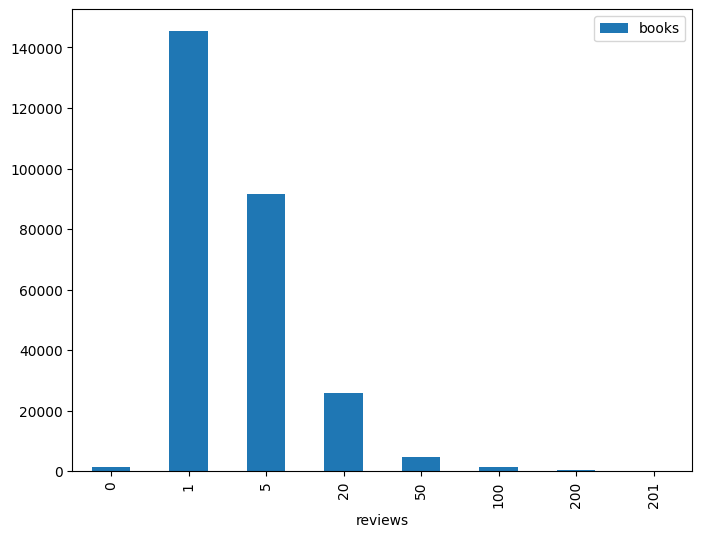

In [285]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.ticklabel_format(useOffset=False, style='plain')
spark.sql("""SELECT 
        case
            when votes = 0 OR votes is null then 0
            when votes = 1 then 1
            when votes > 1 and votes <= 5 then 5
            when votes > 5 and votes <= 20 then 20
            when votes > 20 and votes <= 50 then 50
            when votes > 50 and votes <= 100 then 100
            when votes > 100 and votes <= 200 then 200
        ELSE 201
        END as reviews,
        count(distinct b.isbn) as books
    FROM tmp_db_books b
        left join (select isbn, count(1) as votes from tmp_db_ratings group by 1) as t
          on t.isbn = b.isbn
    group by 1
    order by 1
""").toPandas().plot.bar(x='reviews', y='books',  ax=ax)
plt.show()

## Score dos Livros por faixa de Review

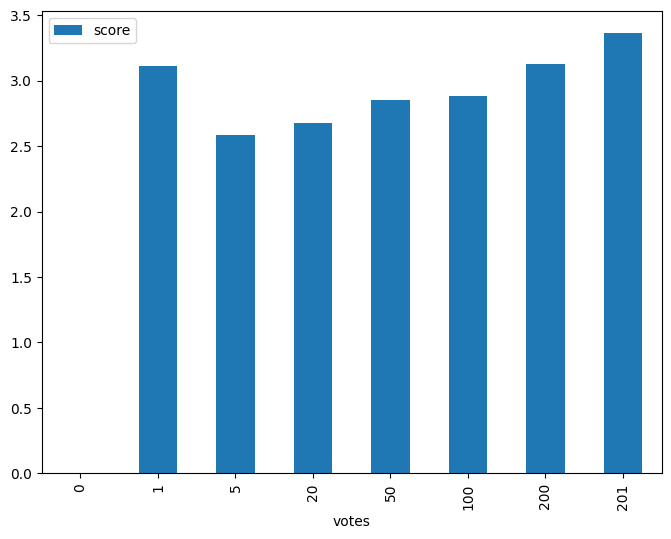

In [283]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.ticklabel_format(useOffset=False, style='plain')
df = spark.sql("""
    SELECT 
        case
            when votes = 0 OR votes is null then 0
            when votes = 1 then 1
            when votes > 1 and votes <= 5 then 5
            when votes > 5 and votes <= 20 then 20
            when votes > 20 and votes <= 50 then 50
            when votes > 50 and votes <= 100 then 100
            when votes > 100 and votes <= 200 then 200
        ELSE 201
        END as votes,
        avg(avg_score) as score
    FROM tmp_db_books b
        left join (select isbn, count(1) as votes, avg(rating) as avg_score from tmp_db_ratings group by 1) as t
          on t.isbn = b.isbn
    group by 1
    order by 1
""").toPandas().plot.bar(x='votes', y='score',  ax=ax)
plt.show()

<Axes: title={'center': 'score'}, xlabel='[votes]'>

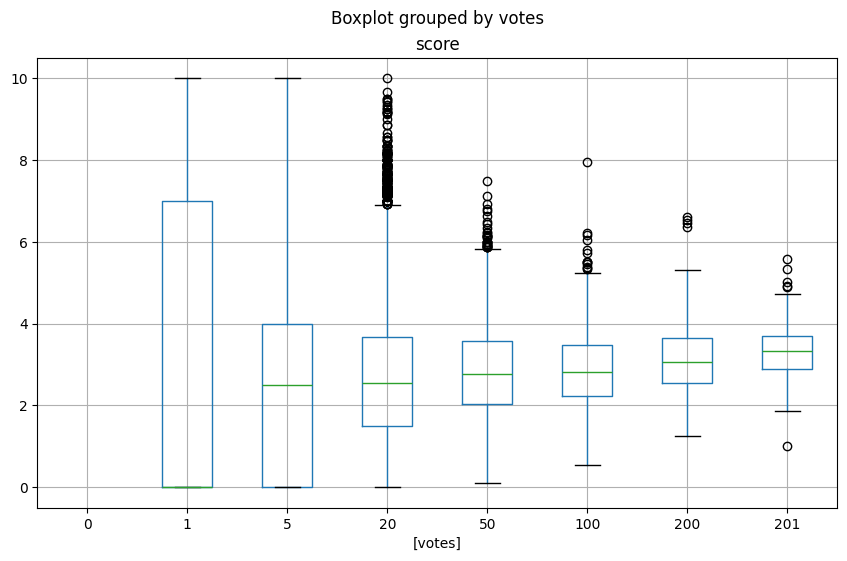

In [288]:
spark.sql("""
    SELECT 
        case
            when votes = 0 OR votes is null then 0
            when votes = 1 then 1
            when votes > 1 and votes <= 5 then 5
            when votes > 5 and votes <= 20 then 20
            when votes > 20 and votes <= 50 then 50
            when votes > 50 and votes <= 100 then 100
            when votes > 100 and votes <= 200 then 200
        ELSE 201
        END as votes,
        avg_score as score
    FROM tmp_db_books b
        left join (select isbn, count(1) as votes, avg(rating) as avg_score from tmp_db_ratings group by 1) as t
          on t.isbn = b.isbn
    -- group by 1
    -- order by 1
""").toPandas().boxplot(by='votes', figsize=(10,6))

# Quantidade de Livros por pontuação de Rating

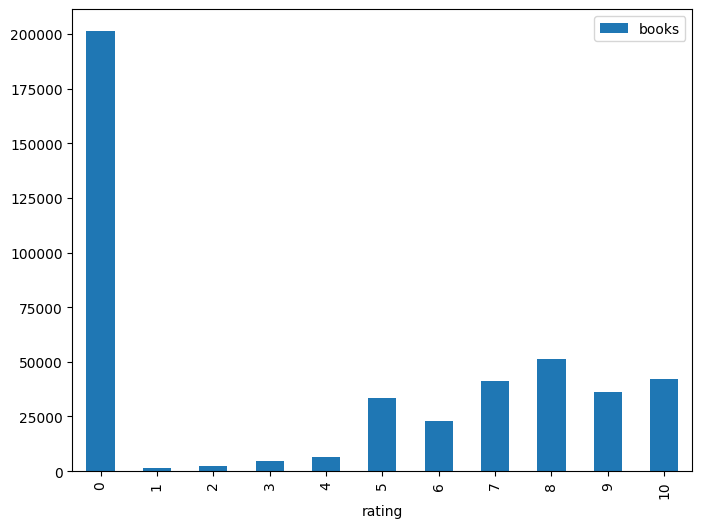

In [82]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.ticklabel_format(useOffset=False, style='plain')
spark.sql("""
    SELECT 
        rating,
        count(distinct isbn) as books
    FROM tmp_db_ratings
    group by 1
    order by 1
""").toPandas().plot.bar(x='rating', y='books',  ax=ax)
plt.show()

# Livros que compartilham o mesmo Autor e Título mas são edições diferentes

In [310]:
spark.sql("""
    SELECT
        title,
        author,
        count(distinct isbn) as editions
    FROM
        tmp_db_books
    GROUP BY
        1,2
    HAVING editions > 1
    ORDER BY editions desc
""").show(200, False)

+---------------------------------------------------------------+---------------------------+--------+
|title                                                          |author                     |editions|
+---------------------------------------------------------------+---------------------------+--------+
|Little Women                                                   |Louisa May Alcott          |21      |
|Adventures of Huckleberry Finn                                 |Mark Twain                 |20      |
|Wuthering Heights                                              |Emily Bronte               |20      |
|Pride and Prejudice                                            |Jane Austen                |18      |
|Dracula                                                        |Bram Stoker                |16      |
|The Secret Garden                                              |Frances Hodgson Burnett    |16      |
|Great Expectations                                             |Charles 

In [311]:
spark.sql("""
    SELECT
        count(1) as qty_books_with_multi_editions,
        sum(editions) as editions,
        count(if(editions = 2, 1, null)) as 2_editions
    FROM      
        (SELECT
            title,
            author,
            count(distinct isbn) as editions
        FROM
            tmp_db_books
        GROUP BY
            1,2
        HAVING editions > 1
        ORDER BY editions desc
        ) as t
""").show(10, False)

+-----------------------------+--------+----------+
|qty_books_with_multi_editions|editions|2_editions|
+-----------------------------+--------+----------+
|15463                        |35215   |12789     |
+-----------------------------+--------+----------+



# 

# Proporção de ratings com valor Zero e não Zero

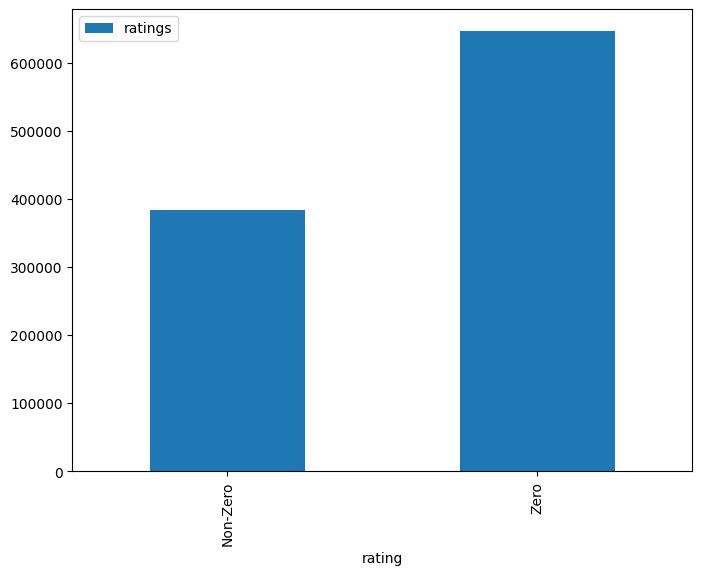

In [81]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.ticklabel_format(useOffset=False, style='plain')
spark.sql("""
    SELECT 
        IF(rating = 0, 'Zero', 'Non-Zero') as rating,
        count(1) as ratings
    FROM tmp_db_ratings
    group by 1
    order by 1
""").toPandas().plot.bar(x='rating', y='ratings',  ax=ax)
plt.show()

# 44% dos Livros possuem uma média de avalição como Zero.
Vamos considerar esses Livros como Livros que não deveriam ser recomendados.

In [230]:
spark.sql("""
    SELECT
        count(distinct b.isbn) as books,
        count(distinct if(t.score = 0, t.isbn, null)) as no_recommended_book,
        count(distinct if(t.score = 0, t.isbn, null)) / count(distinct b.isbn) as share_no_recommended_book,
        avg(if(t.score = 0, t.votes, null)) as no_recommended_books_avg_votes
    FROM
        tmp_db_books b
        LEFT JOIN
            (SELECT 
                isbn,
                count(1) as votes,
                avg(rating) as score
            FROM tmp_db_ratings
            GROUP BY 1
            ) as t
        ON b.isbn = t.isbn
""").show()

+------+-------------------+-------------------------+------------------------------+
| books|no_recommended_book|share_no_recommended_book|no_recommended_books_avg_votes|
+------+-------------------+-------------------------+------------------------------+
|271065|             120103|       0.4430782284691864|            1.4935929993422312|
+------+-------------------+-------------------------+------------------------------+



### Cria uma tabela temporária com os dados de livros que não devemos recomendar para utilizar nas análises seguintes

In [234]:
spark.sql("""
    SELECT
        *
    FROM
        (SELECT 
            isbn,
            count(1) as votes,
            avg(rating) as score
        FROM tmp_db_ratings
        GROUP BY 1
        ) as t
    WHERE
        score = 0
""").createOrReplaceTempView("tmp_no_recommended_books")

# Gera recomendação para todos os Livros da base utilizando os 2 modelos
O objetivo aqui é tentar tirar métricas de comparação entre os resultados dos dois modelos.

### Desserializa os modelos gerados pelo notebook (books-recommendation-db)

In [87]:
knn_cosine_model = {}
knn_euclidean_model = {}
item_user_csr = {}
isbn_encoder = {}

with open('../recommendation-api/models/cosine/book_recommendation_model.pickle', 'rb') as f:
    knn_cosine_model = pickle.load(f)

with open('../recommendation-api/models/euclidean/book_recommendation_model.pickle', 'rb') as f:
    knn_euclidean_model = pickle.load(f)

with open('../recommendation-api/models/book_recommendation_matrix.pickle', 'rb') as f:
    item_user_csr = pickle.load(f)

with open('../recommendation-api/models/book_recommendation_encoder.pickle', 'rb') as f:
    isbn_encoder = pickle.load(f)

### Função de recomendação

In [88]:
def getCosineRecommendations(isbn):
    n = 5
    default_n = 10
    limit = len(isbn_encoder.classes_)
    n_request = default_n if n*2 < 1 or n*2 > min(default_n,limit) else n*2

    try:
        item_index = isbn_encoder.transform([isbn])
        distances, indices = knn_cosine_model.kneighbors(item_user_csr[item_index], n_neighbors=n_request)
        recommendations = list(isbn_encoder.inverse_transform(indices.flatten()))
        recommendations = list(filter(lambda x: x != isbn, recommendations))
        return recommendations[:n]
    except Exception as e:
        print(e)
        return []

In [89]:
def getEuclideanRecommendations(isbn):
    n = 5
    default_n = 10
    limit = len(isbn_encoder.classes_)
    n_request = default_n if n*2 < 1 or n*2 > min(default_n,limit) else n*2

    try:
        item_index = isbn_encoder.transform([isbn])
        distances, indices = knn_euclidean_model.kneighbors(item_user_csr[item_index], n_neighbors=n_request)
        recommendations = list(isbn_encoder.inverse_transform(indices.flatten()))
        recommendations = list(filter(lambda x: x != isbn, recommendations))
        return recommendations[:n]
    except Exception as e:
        print(e)
        return []

### Carrega todos os ISBNs dos livros para iniciar o processo de gerar as recomendações

In [ ]:
isbns = spark.sql("""
    SELECT 
        isbn
    FROM tmp_db_books
    group by 1
""").toPandas()

### Executa de fato as recomendações para todos os livros
Esse processo é bem custoso e levou mais de 4.6h para executar, então ao final vamos persistir os resultados em parquet para não perdermos os dados

In [99]:
isbns_cosine = isbns.copy(deep=True)
isbns_cosine['recommendations'] = DataFrameParallel(isbns_cosine, 8, True)['isbn'].apply(getCosineRecommendations)

/home/allan/Workspace/MLET-module-3-main/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
Process-25: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


y contains previously unseen labels: '0028633784'


Process-20: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


In [100]:
isbns_euclidean = isbns.copy(deep=True)
isbns_euclidean['recommendations'] = DataFrameParallel(isbns_euclidean, 8, True)['isbn'].apply(getEuclideanRecommendations)

/home/allan/Workspace/MLET-module-3-main/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
Process-34: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


y contains previously unseen labels: '0028633784'


Process-29: 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


# Persiste os dados em um parquet para análises

In [118]:
cosine_data = spark.createDataFrame(isbns_cosine.explode(['recommendations']))
cosine_data.write.mode("overwrite").parquet("./data_cosine")
euclidean_data = spark.createDataFrame(isbns_euclidean.explode(['recommendations']))
euclidean_data.write.mode("overwrite").parquet("./data_euclidean")

In [124]:
spark.read.parquet("./data_cosine").createOrReplaceTempView("tmp_cosine")
spark.read.parquet("./data_euclidean").createOrReplaceTempView("tmp_euclidean")

# Exibe o percentual de livros (em relação ao total) que apareceu nas recomendações para cada modelo

In [149]:
spark.sql("""
    select 
        (select count(distinct recommendations) from tmp_cosine)
          /
        (select count(distinct isbn) from tmp_db_books) as cosine_recommended_books_share
""").show()

+------------------------------+
|cosine_recommended_books_share|
+------------------------------+
|            0.3490897017320569|
+------------------------------+



In [151]:
spark.sql("""
    select 
        (select count(distinct recommendations) from tmp_euclidean)
          /
        (select count(distinct isbn) from tmp_db_books) as euclidean_recommended_books_share 
""").show()

+---------------------------------+
|euclidean_recommended_books_share|
+---------------------------------+
|               0.3201519930643941|
+---------------------------------+



# Quantos livros que não deveríamos recomendar cada modelo recomendou?

In [235]:
spark.sql("""
    select 
        count(distinct c.isbn) as source_books,
        count(distinct recommendations) as cosine_errors,
        count(1) as items,
        avg(score) as avg_score,
        avg(votes) as avg_votes
    from tmp_cosine c
        left join (select isbn, avg(rating) as score, count(1) as votes from tmp_db_ratings group by 1) as r
          on r.isbn = c.isbn
    where 
        recommendations in (select isbn from tmp_no_recommended_books)
        and c.isbn not in (select isbn from tmp_no_recommended_books)
""").show()

+------------+-------------+-----+-----------------+-----------------+
|source_books|cosine_errors|items|        avg_score|        avg_votes|
+------------+-------------+-----+-----------------+-----------------+
|       20684|            3|48520|5.408951638232126|1.994270403957131|
+------------+-------------+-----+-----------------+-----------------+



In [236]:
spark.sql("""
    select 
        count(distinct c.isbn) as source_books,
        count(distinct recommendations) as euclidean_errors,
        count(1) as items,
        avg(score) as avg_score,
        avg(votes) as avg_votes
    from tmp_euclidean c
        left join (select isbn, avg(rating) as score, count(1) as votes from tmp_db_ratings group by 1) as r
          on r.isbn = c.isbn
    where 
        recommendations in (select isbn from tmp_no_recommended_books)
        and c.isbn not in (select isbn from tmp_no_recommended_books)
""").show()

+------------+----------------+------+------------------+------------------+
|source_books|euclidean_errors| items|         avg_score|         avg_votes|
+------------+----------------+------+------------------+------------------+
|       36855|            1949|137915|4.9955566474788915|2.2615306529384043|
+------------+----------------+------+------------------+------------------+



# Semelhanças nas Recomendações

In [221]:
spark.sql("""select count(1) as total, count(distinct recommendations) as recommendations from tmp_cosine""").show()

+-------+---------------+
|  total|recommendations|
+-------+---------------+
|1350121|          94626|
+-------+---------------+



In [222]:
spark.sql("""select count(1) as total, count(distinct recommendations) as recommendations from tmp_euclidean""").show()

+-------+---------------+
|  total|recommendations|
+-------+---------------+
|1350121|          86782|
+-------+---------------+



### Se desconsiderarmos a ordem em que os livros são recomendados, apenas 16% das recomendações entre os 2 modelos são iguais.
Estou considerando "recomendalção" o par de livro de origem + livro recomendado

In [184]:
spark.sql("""
    select 
        count(1) as lines,
        count(if(e.isbn = c.isbn, 1, null)) as match,
        count(if(e.isbn = c.isbn, 1, null)) / count(1) as match_share
    from tmp_cosine c 
        left join tmp_euclidean e
          on c.isbn = e.isbn and e.recommendations = c.recommendations
""").show()

+-------+------+-------------------+
|  lines| match|        match_share|
+-------+------+-------------------+
|1350121|226725|0.16792939299514636|
+-------+------+-------------------+



# Olhando de forma geral o corpus de Livros recomendados (dos 2 modelos), 60% são iguais

In [292]:
spark.sql("""
    SELECT
        count(1) as lines,
        count(distinct t.recommendations) as cosine_recommendations,
        count(t2.recommendations) as euclidean_recommendations,
        count(IF(t.recommendations is not null and t2.recommendations is not null, 1,null)) as similar_recommendations,
        count(IF(t.recommendations is not null and t2.recommendations is not null, 1,null)) / count(1) as similarity
    FROM
        (select 
            recommendations
        from tmp_cosine c 
        group by 1
        ) as t
    full outer join 
        (select
            recommendations
        from tmp_euclidean
        group by 1
        ) as t2 
        ON t.recommendations = t2.recommendations
""").show()

+------+----------------------+-------------------------+-----------------------+------------------+
| lines|cosine_recommendations|euclidean_recommendations|similar_recommendations|        similarity|
+------+----------------------+-------------------------+-----------------------+------------------+
|114018|                 94626|                    86782|                  67390|0.5910470276622989|
+------+----------------------+-------------------------+-----------------------+------------------+



In [206]:
spark.sql("""
    select 
        isbn, 
        avg(rating) as avg_rating, 
        count(1) as votes,   
        avg(rating) *0.2 + count(1)*0.05 as score
    from tmp_db_ratings group by 1
""").createOrReplaceTempView("tmp_book_scores")

<Axes: title={'center': 'score'}, xlabel='[votes]'>

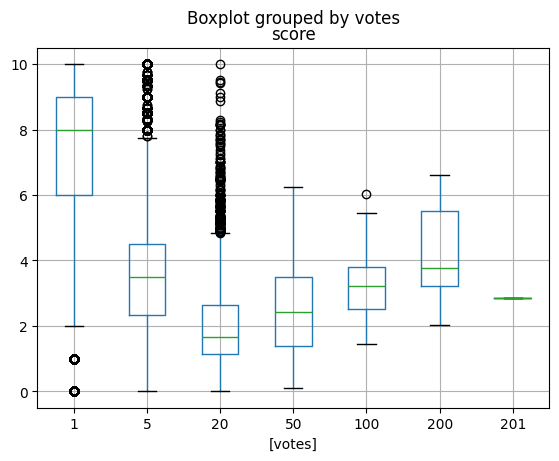

In [297]:
spark.sql("""
    SELECT
        case
            when votes = 0 OR votes is null then 0
            when votes = 1 then 1
            when votes > 1 and votes <= 5 then 5
            when votes > 5 and votes <= 20 then 20
            when votes > 20 and votes <= 50 then 50
            when votes > 50 and votes <= 100 then 100
            when votes > 100 and votes <= 200 then 200
        ELSE 201
        END as votes,
        avg_rating as score
    FROM
        tmp_book_scores
    WHERE
        isbn IN (select recommendations from tmp_euclidean group by 1)
""").toPandas().boxplot(by='votes')

<Axes: title={'center': 'score'}, xlabel='[votes]'>

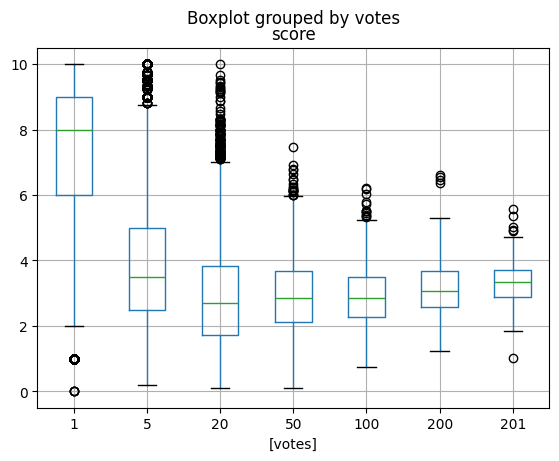

In [298]:
spark.sql("""
    SELECT
        case
            when votes = 0 OR votes is null then 0
            when votes = 1 then 1
            when votes > 1 and votes <= 5 then 5
            when votes > 5 and votes <= 20 then 20
            when votes > 20 and votes <= 50 then 50
            when votes > 50 and votes <= 100 then 100
            when votes > 100 and votes <= 200 then 200
        ELSE 201
        END as votes,
        avg_rating as score
    FROM
        tmp_book_scores
    WHERE
        isbn IN (select recommendations from tmp_cosine group by 1)
""").toPandas().boxplot(by='votes')